In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

gl.canvas.set_target('ipynb')

PATH_TO_JSON2 = "/mnt/sframe/docs_prod_02/"
PATH_TO_JSON = "/mnt/sframe/docs_prod_03/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

[WARNING] This Python session does not appear to be running in an interactive IPython Notebook. Use of the 'ipynb' target may behave unexpectedly or result in errors.


### Read processed documents

In [2]:
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 128)

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-15017 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1442940041.log
[INFO] GraphLab Server Version: 1.6


In [3]:
# documents
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False, verbose=False)
sf = sf.unpack('X1',column_name_prefix='')
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))
sf['num_words'] = sf['text'].apply(lambda xs: transf(len(xs)))

sf2 = gl.SFrame.read_csv(PATH_TO_JSON2, header=False, verbose=False)
sf2 = sf2.unpack('X1',column_name_prefix='')
sf2['id'] = sf2['id'].apply(lambda x: str(x.split('_')[0] ))

In [9]:
def transf(x):
    return 50.0 * np.log1p(np.log1p(x))

sf_cnt = gl.SFrame()
sf_cnt['id'] = sf2['id']

sf_cnt['a_href'] = sf2['ahref'].apply(lambda x: transf(len(x)))
sf_cnt['par'] = sf2['par'].apply(lambda x: transf(len(x)))
sf_cnt['title'] = sf2['title'].apply(lambda x: transf(len(x)))

sf_cnt['img'] = sf2['img_cnt'].apply(transf)
sf_cnt['btn'] = sf2['misc_button'].apply(transf)
sf_cnt['input'] = sf2['misc_input'].apply(transf)
sf_cnt['li'] = sf2['misc_li'].apply(transf)
sf_cnt['link'] = sf2['misc_link'].apply(transf)
sf_cnt['meta'] = sf2['misc_meta'].apply(transf)

sf_cnt['script_avg'] = sf2['script_avg'].apply(transf)
sf_cnt['script_b_avg'] = sf2['script_b_avg'].apply(transf)
sf_cnt['script_cnt'] = sf2['script_cnt'].apply(transf)
sf_cnt['script_b_cnt'] = sf2['script_b_cnt'].apply(transf)

sf_cnt['style_avg'] = sf2['style_avg'].apply(transf)
sf_cnt['style_cnt'] = sf2['style_cnt'].apply(transf)

### Read train/test labels and merge into documents

In [10]:
# train/test labels
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS, verbose=False)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS, verbose=False)
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

# join
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

train = train.join(sf_cnt, on='id', how='left')
test = test.join(sf_cnt, on='id', how='left')

In [11]:
features = [
            'a_href',
            'par',
            'title',
            'img',
            'btn',
            'input',
            'li',
            'link',
            'meta',
            'script_avg',
            'script_b_avg',
            'script_cnt',
            'script_b_cnt',
            'style_avg',
            'style_cnt',
            'num_words'
           ]

# fill in empty
for f in features:
    train = train.fillna(f, 0.0)     
    test = test.fillna(f, 0.0)

### Generate BOW

In [13]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

### Generate TF-IDF

In [14]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf', min_document_frequency=1e-5))
train = encoder.transform(train)
test = encoder.transform(test)

### Hash TF-IDF

In [15]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=18, 
                                                                  output_column_name='tfidf_hashed_18'))
train['tfidf_hashed_18'] = hash_encoder.transform(train)['tfidf_hashed_18']
test['tfidf_hashed_18'] = hash_encoder.transform(test)['tfidf_hashed_18']

### Split training set for cross-validation

In [16]:
train_train, train_cv = train.random_split(0.80, seed=107)

# Generate Submission Model

In [ ]:
model = gl.classifier.boosted_trees_classifier.create(train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=None)

In [ ]:
lr_model = gl.logistic_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,
                                      class_weights='auto',
                                      max_iterations=10,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
svm_model = gl.svm_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,                                           
                                      class_weights='auto',
                                      max_iterations=20)

### Output model

In [ ]:
ypred = model.predict(test, 'probability')

submission = gl.SFrame()
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission['sponsored'] = ypred 
#submission.save('submission_version_4.csv', format='csv')

submission = submission.to_dataframe()
submission.to_csv('submission_version_6_boosted_try2.csv', index=False, float_format='%1.8f')

In [ ]:
model.save('/mnt/sframe/model_RF_100_100_040_100_bits18')

In [ ]:
test

# Experiment

### Split train into *train_train*/*train_cv*

In [ ]:
model = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=features, # + ['tfidf_hashed'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=10,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
results = gl.SFrame()
results['id'] = train_cv['id']
results['actual'] = train_cv['sponsored']
results['predicted'] = model.predict(train_cv)

In [ ]:
train_cv.unpack('tfidf')

In [ ]:
FN.shape, FP.shape

In [ ]:
FN = results[results['actual'] > results['predicted']]
FP = results[results['actual'] < results['predicted']]

In [ ]:
FN[720:730]

In [ ]:
FP

In [ ]:
model.evaluate(train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv.remove_column('tfidf_hashed17')

In [ ]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf_hashed'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=15)

In [ ]:
svm_model

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']].sort('margin')
train_cv.remove_column('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])



In [ ]:
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']]
preds['margin'].show()

In [ ]:
(preds[preds['margin'] < 55]['sponsored']).sum()

In [ ]:
ts = np.arange(-22, 50, 0.1)
[for t in ts]

In [ ]:
svm_model.evaluate(train_cv)

In [ ]:
results = svm_model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
results

# Save Datasets?

In [ ]:
train_train.save('dataset_train_train')
train_cv.save('dataset_train_cv')
test.save('dataset_test')

# Junk

In [ ]:
hash_encoder = gl.feature_engineering.create(train_train, FeatureHasher(features = ['tfidf'], num_bits=17, 
                                                                  output_column_name='tfidf_hashed_17'))
train_train['tfidf_hashed_17'] = hash_encoder.transform(train_train)['tfidf_hashed_17']
train_cv['tfidf_hashed_17'] = hash_encoder.transform(train_cv)['tfidf_hashed_17']

In [ ]:
train_train.head()

In [ ]:
model_15 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=40,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_15

In [ ]:
model_15.evaluate(train_cv)

In [ ]:
results = model_15.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_16 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=20,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_16.evaluate(train_cv)

In [ ]:
results = model_16.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=8,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=7,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17.evaluate(train_cv)

In [ ]:
results = model_17.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [19]:
train.head()

sponsored,id,text,num_words,a_href,par,title
0,920982,bill gate world richestmost time beaten norweg ...,110.523456365,80.9005654591,59.7352761659,78.5001487104
0,920988,credit netflix fandomleah tedesco follow ...,114.387098481,91.3477694121,69.8681740587,74.8217008302
0,920992,bimota,58.1141556942,0.0,0.0,63.5574924142
0,921036,make your reflect yourpoint across with thi ...,114.049972914,93.0436382317,26.329451707,83.4236762641
0,921040,play music suppos remembsometim electron ...,112.613842571,87.1068371903,70.9803420755,82.6201544047
0,921050,ecogrid ecorast ecogridecorast ecogrid ecorast ...,106.827848532,83.5500516371,67.185172233,83.6744408005
0,921108,topic sunday polic chargyear jeffrey william ...,113.745110547,83.0320189667,76.9889728976,82.7598076253
1,921123,celebr your passion hobbiwith great video more ...,110.10144076,69.2613429966,70.4399908075,81.5685200098
1,921127,local queri searchlanguag countri ...,91.5204910746,54.0208909136,0.0,78.5001487104
0,921130,they necess mother inventwhat they neglect men ...,117.816844008,92.4373694772,72.8823191511,82.3333585635


In [ ]:
#train = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_train')
#test = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_test')

In [20]:
#train.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_train')
#test.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_test')

#train_train.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_train')
#train_cv.save('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_cv')
#train_train = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_train')
#train_cv = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_cv')

In [ ]:
train_train.head()

In [ ]:
model = gl.classifier.random_forest_classifier.create?

In [ ]:
train_train_16 = train_train
train_cv_16 = train_cv
train_train = train_train_18
train_cv = train_cv_18

In [ ]:
model = gl.classifier.random_forest_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      num_trees=10,
                                                      max_depth=100,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [17]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

PROGRESS: WARNING: Detected extremely low variance for feature(s) 'tfidf_hashed_18' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.
PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 269988
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 17
PROGRESS: Number of unpacked features : 214796
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   6.191e-01   6.196e-01        6.93s
PROGRESS:      1   6.696e-01   6.670e-01       14.03s
PROGRESS:      2   6.842e-01   6.812e-01       20.76s
PROGRESS:      3   7.071e-01   7.023e-01       27.59s
PROGRESS:

AUC = 0.924389


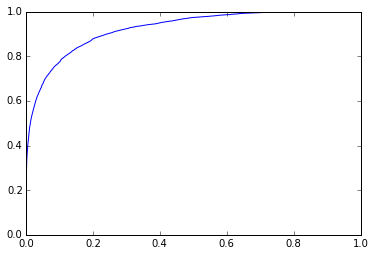

In [18]:
results = model_boosted.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.boosted_trees_classifier.get_default_options()

In [22]:
TRAIN, CV = train_cv.random_split(0.50, seed=113)

In [25]:
CV.shape

(33440, 22)

In [27]:
model_boosted = gl.classifier.boosted_trees_classifier.create(TRAIN, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=500,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=CV)

PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 33596
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 17
PROGRESS: Number of unpacked features : 173435
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   5.837e-01   5.710e-01        1.16s
PROGRESS:      1   6.704e-01   6.412e-01        2.20s
PROGRESS:      2   7.004e-01   6.700e-01        3.26s
PROGRESS:      3   7.199e-01   6.900e-01        4.33s
PROGRESS:      4   7.300e-01   6.953e-01        5.41s
PROGRESS:      5   7.361e-01   7.028e-01        6.49s
PROGRESS:      6   7.481e-01   7.110e-01        7.58s
PROGRESS:      7   7.581e-01   7.191e-01        8.61s
PROGRESS:      8   7.611e-01   7.188e-01        9.74s
PROGRESS:      9   7.666e-01   7.220e-

AUC = 0.881189


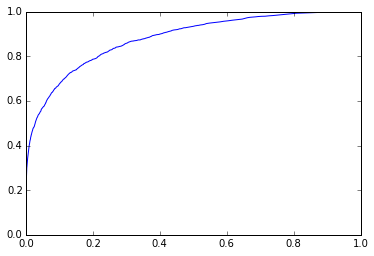

In [28]:
results = model_boosted.evaluate(CV, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [31]:
model_boosted = gl.classifier.boosted_trees_classifier.create(TRAIN, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=50,
                                                      column_subsample=0.2,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=CV)

PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 33596
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 17
PROGRESS: Number of unpacked features : 173435
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   6.371e-01   6.330e-01        1.18s
PROGRESS:      1   6.605e-01   6.418e-01        2.18s
PROGRESS:      2   6.980e-01   6.719e-01        3.27s
PROGRESS:      3   7.196e-01   6.895e-01        4.32s
PROGRESS:      4   7.277e-01   7.008e-01        5.34s
PROGRESS:      5   7.427e-01   7.095e-01        6.39s
PROGRESS:      6   7.506e-01   7.122e-01        7.48s
PROGRESS:      7   7.554e-01   7.163e-01        8.50s
PROGRESS:      8   7.584e-01   7.182e-01        9.59s
PROGRESS:      9   7.589e-01   7.174e-

AUC = 0.865102


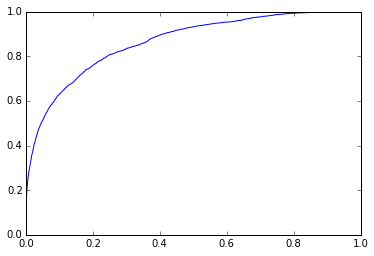

In [32]:
results = model_boosted.evaluate(CV, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [40]:
def custom_evaluator(model, train, test):
    results = model.evaluate(test, metric='roc_curve')
    a = results['roc_curve']

    fpr = list(a['fpr'])
    tpr = list(a['tpr'])
    fpr[0] = 1.0
    tpr[0] = 1.0
    fpr = np.array(fpr)
    tpr = np.array(tpr)

    AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
    return {'AUC': AUC}

params = dict([
        ('target', 'sponsored'),
        ('features', [features + ['tfidf_hashed_18']]),
        ('max_depth', [5,6]),
        ('step_size', scipy.stats.distributions.expon(.1)),
        ('max_iterations', 50),
        ('column_subsample', 0.2),
        ('validation_set', None)
    ])

job = gl.random_search.create((TRAIN, CV), 
                              gl.boosted_trees_regression.create, 
                              params, 
                              custom_evaluator=custom_evaluator)
job.get_results()

[INFO] Validating job.
[INFO] Validation complete. Job: 'Model-Parameter-Search-Sep-22-2015-18-28-4400000' ready for execution
[INFO] Job: 'Model-Parameter-Search-Sep-22-2015-18-28-4400000' scheduled.
[INFO] Validating job.
[INFO] A job with name 'Model-Parameter-Search-Sep-22-2015-18-28-4400000' already exists. Renaming the job to 'Model-Parameter-Search-Sep-22-2015-18-28-4400000-1fa73'.
[INFO] Validation complete. Job: 'Model-Parameter-Search-Sep-22-2015-18-28-4400000-1fa73' ready for execution
[INFO] Job: 'Model-Parameter-Search-Sep-22-2015-18-28-4400000-1fa73' scheduled.


Columns:
	model_id	int
	column_subsample	float
	features	list
	max_depth	int
	max_iterations	int
	step_size	float
	target	str
	training_rmse	float
	validation_rmse	float

Rows: 6

Data:
+----------+------------------+-------------------------------+-----------+----------------+
| model_id | column_subsample |            features           | max_depth | max_iterations |
+----------+------------------+-------------------------------+-----------+----------------+
|    9     |       0.2        | [a_href, par, title, img, ... |     5     |       50       |
|    1     |       0.2        | [a_href, par, title, img, ... |     6     |       50       |
|    0     |       0.2        | [a_href, par, title, img, ... |     5     |       50       |
|    3     |       0.2        | [a_href, par, title, img, ... |     6     |       50       |
|    7     |       0.2        | [a_href, par, title, img, ... |     6     |       50       |
|    6     |       0.2        | [a_href, par, title, img, ... |     5     |       50       |
+----------+------------------+-------------------------------+-----------+----------------+
+----------------+-----------+----------------+-----------------+
|   step_size    |   target  | training_rmse  | validation_rmse |
+----------------+-----------+----------------+-----------------+
| 0.810218165893 | sponsored | 0.205914231507 |  0.252365476618 |
| 0.913943257397 | sponsored | 0.197789406259 |  0.251504429942 |
| 0.211369425181 | sponsored | 0.235732220331 |  0.252156361881 |
| 0.403171504462 | sponsored | 0.214917252413 |  0.246636355291 |
| 0.254732241262 | sponsored | 0.224419633323 |  0.248449025931 |
| 0.151686379473 | sponsored | 0.245801089628 |  0.258382879767 |
+----------------+-----------+----------------+-----------------+
[6 rows x 9 columns]

In [41]:
job.get_metrics()

task_name,status,start_time,run_time,exception,exception_message
_train_test_model-0-0,Completed,2015-09-22 18:30:05,42.9287319183,None,None
_train_test_model-0-1,Completed,2015-09-22 18:30:48,42.4172270298,None,None
_train_test_model-0-2,Failed,2015-09-22 18:31:31,None,ToolkitError,"Option 'step_size' mustbe in the range [0, 1]. ..."
_train_test_model-0-3,Completed,2015-09-22 18:31:35,42.8648118973,None,None
_train_test_model-0-4,Failed,2015-09-22 18:32:18,None,ToolkitError,"Option 'step_size' mustbe in the range [0, 1]. ..."
_train_test_model-0-5,Failed,2015-09-22 18:32:21,None,ToolkitError,"Option 'step_size' mustbe in the range [0, 1]. ..."
_train_test_model-0-6,Completed,2015-09-22 18:32:24,42.9050049782,None,None
_train_test_model-0-7,Completed,2015-09-22 18:33:07,41.8573458195,None,None
_train_test_model-0-8,Failed,2015-09-22 18:33:49,None,ToolkitError,"Option 'step_size' mustbe in the range [0, 1]. ..."
_train_test_model-0-9,Completed,2015-09-22 18:33:53,42.8231611252,None,None


In [39]:
features + ['tfidf_hashed_18']

['a_href',
 'par',
 'title',
 'img',
 'btn',
 'input',
 'li',
 'link',
 'meta',
 'script_avg',
 'script_b_avg',
 'script_cnt',
 'script_b_cnt',
 'style_avg',
 'style_cnt',
 'num_words',
 'tfidf_hashed_18']